In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from ocrlib import slog
from imp import reload
from ocrlib import ocroseg
import webdataset as wds
import scipy.ndimage as ndi
import torchmore

In [3]:
import torch
torch.cuda.is_available()

True

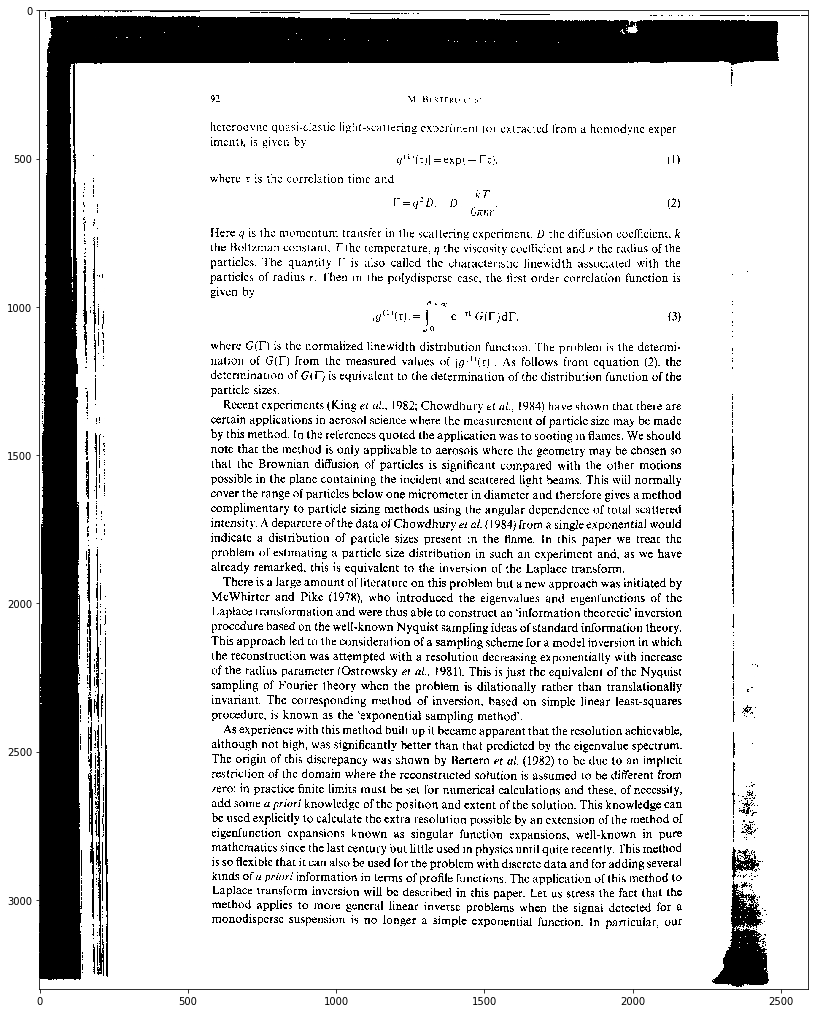

In [4]:
figsize(24, 18)
ds = wds.Dataset("uw3/uw3-hocr.tar").decode()
src = iter(ds)

In [ ]:
sample = next(src)
page = sample["page.jpg"]
page = page[:,:,1]
imshow(page)

In [7]:
print(sample["hocr.html"].decode("utf8"))

<html>
<head>
<meta name='langs' content='English'>
<meta name='scripts' content='Roman'>
<meta name='character_orientation' content='up-right'>
<meta name='degradation_type' content='photocopy'>
<meta name='document_type' content='journal'>
<meta name='publication_name' content='Journal of Aerosol Science'>
<meta name='publication_date' content='1989'>
<meta name='page_id' content='A053'>
<meta name='page_number' content='92'>
<meta name='text_reading_direction' content='left-right'>
<meta name='displayed_math_present' content='Y'>
<meta name='dominant_font_type' content='serif'>
<meta name='dominant_font_style' content='plain'>
<meta name='dominant_font_spacing' content='proportional'>
<meta name='dominant_font_size' content='9-12'>
<meta name='drawing_present' content='N'>
<meta name='extras_top_edge' content='N'>
<meta name='extras_left_edge' content='N'>
<meta name='extras_right_edge' content='N'>
<meta name='extras_bottom_edge' content='N'>
<meta name='header_present' content='Y'

In [40]:
from ocrlib import pagerec
reload(pagerec)
pr = pagerec.PageRecognizer()
pr.load_lineseg("models/lineseg.pth")
pr.load_segmenter("models/seglstm.pth")
pr.load_recognizer("models/rawlinemodel.pth")

In [41]:
result = pr.recognize_lines(page)

# segmenting
torch.Size([1, 1, 1656, 1296])
# recognizing
# line segmentation
torch.Size([1, 1, 1656, 1296])


In [42]:
for line in result["lines"]:
    text = [w["output"] for w in line["words"]]
    print(" ".join(text))
    
print(result["extra"])

M. BERTER0 gt
a.
heterodyne quasi-elastic light-scattering experiment (or extracted from a homodyne exper-
iment), is given by
where \ is the correlation time and
Here q is the momentum transfer in the scattering experiment, D the diffusion coefficient, k
the Boltzman constant, T the temperature, n the viscosity coefficient and r the radius of the
particles. The quantity F is also called the characteristic linewidth associated with the
particles of radius r. Then in the polydisperse case, the first order correlation function is
given by
where G(T) is the normalized linewidth distribution function. The problem is the determi-
nation of G(I) from the measured values of [g\1 ()m]. As follows from equation (2), the
determination of G(I) is equivalent to the determination of the distribution function of the
particle sies.
Recent experiments (King et al., 1982; Chowdhury et al., 1984) have shown that there are
certain applications in aerosol science where the measurement of particle size may

In [43]:
class BBox:
    def __init__(self, y0, y1, x0, x1):
        self.y0, self.y1, self.x0, self.x1 = y0, y1, x0, x1
        
    def __getitem__(self, index):
        assert index >=0 and index <= 1
        if index == 0:
            return slice(self.y0, self.y1)
        elif index == 1:
            return slice(self.x0, self.x1)
        
    def union(self, other):
        return BBox(
            min(self.y0, other.y0),
            max(self.y1, other.y1),
            min(self.x0, other.x0),
            max(self.x1, other.x1)
        )
        
    def coords(self):
        return self.y0, self.y1, self.x0, self.x1


def reading_order(lines,highlight=None,debug=0):
    """Given the list of lines (a list of 2D slices), computes
    the partial reading order.  The output is a binary 2D array
    such that order[i,j] is true if line i comes before line j
    in reading order."""
    order = np.zeros((len(lines),len(lines)),'B')
    def x_overlaps(u,v):
        return u[1].start<v[1].stop and u[1].stop>v[1].start
    def above(u,v):
        return u[0].start<v[0].start
    def left_of(u,v):
        return u[1].stop<v[1].start
    def separates(w,u,v):
        if w[0].stop<min(u[0].start,v[0].start): return 0
        if w[0].start>max(u[0].stop,v[0].stop): return 0
        if w[1].start<u[1].stop and w[1].stop>v[1].start: return 1
    if highlight is not None:
        plt.clf()
        plt.title("highlight")
        plt.imshow(binary)
        plt.ginput(1,debug)
    for i,u in enumerate(lines):
        for j,v in enumerate(lines):
            if x_overlaps(u,v):
                if above(u,v):
                    order[i,j] = 1
            else:
                if [w for w in lines if separates(w,u,v)]==[]:
                    if left_of(u,v): order[i,j] = 1
            if j==highlight and order[i,j]:
                print((i, j), end=' ')
                y0,x0 = sl.center(lines[i])
                y1,x1 = sl.center(lines[j])
                plt.plot([x0,x1+200],[y0,y1])
    if highlight is not None:
        print()
        plt.ginput(1,debug)
    return order

def topsort(order):
    """Given a binary array defining a partial order (o[i,j]==True means i<j),
    compute a topological sort.  This is a quick and dirty implementation
    that works for up to a few thousand elements."""
    n = len(order)
    visited = np.zeros(n)
    L = []
    def visit(k):
        if visited[k]: return
        visited[k] = 1
        for l in find(order[:,k]):
            visit(l)
        L.append(k)
    for k in range(n):
        visit(k)
    return L #[::-1]

def find(condition):
    "Return the indices where ravel(condition) is true"
    res, = np.nonzero(np.ravel(condition))
    return res

def show_lines(image,lines,lsort):
    """Overlays the computed lines on top of the image, for debugging
    purposes."""
    ys,xs = [],[]
    plt.clf()
    plt.cla()
    plt.imshow(image)
    for i in range(len(lines)):
        l = lines[lsort[i]]
        y,x = sl.center(l.bounds)
        xs.append(x)
        ys.append(y)
        o = l.bounds
        r = mpatches.Rectangle((o[1].start,o[0].start),edgecolor='r',fill=0,width=sl.dim1(o),height=sl.dim0(o))
        plt.gca().add_patch(r)
    h,w = image.shape
    plt.ylim(h,0)
    plt.xlim(0,w)
    plt.plot(xs,ys)



In [44]:
lines = result["lines"]
boxes = [BBox(*line["box"]) for line in lines]
constraints = reading_order(boxes)
order = topsort(constraints)

In [45]:
lines = [lines[i] for i in order]

In [46]:
for line in lines:
    text = [w["output"] for w in line["words"]]
    print(" ".join(text))
    
print(result["extra"])

M. BERTER0 gt
a.
heterodyne quasi-elastic light-scattering experiment (or extracted from a homodyne exper-
iment), is given by
where \ is the correlation time and
Here q is the momentum transfer in the scattering experiment, D the diffusion coefficient, k
the Boltzman constant, T the temperature, n the viscosity coefficient and r the radius of the
particles. The quantity F is also called the characteristic linewidth associated with the
particles of radius r. Then in the polydisperse case, the first order correlation function is
given by
where G(T) is the normalized linewidth distribution function. The problem is the determi-
nation of G(I) from the measured values of [g\1 ()m]. As follows from equation (2), the
determination of G(I) is equivalent to the determination of the distribution function of the
particle sies.
Recent experiments (King et al., 1982; Chowdhury et al., 1984) have shown that there are
certain applications in aerosol science where the measurement of particle size may

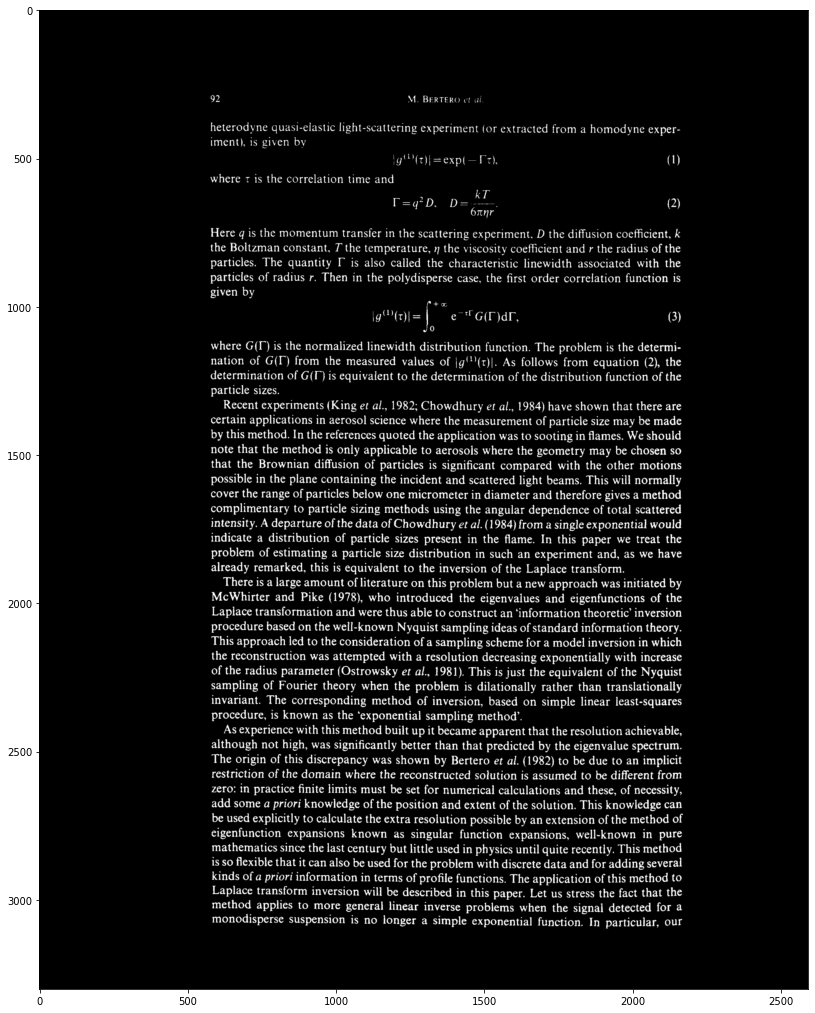

In [47]:
figsize(24, 18); imshow(page,interpolation="bilinear")

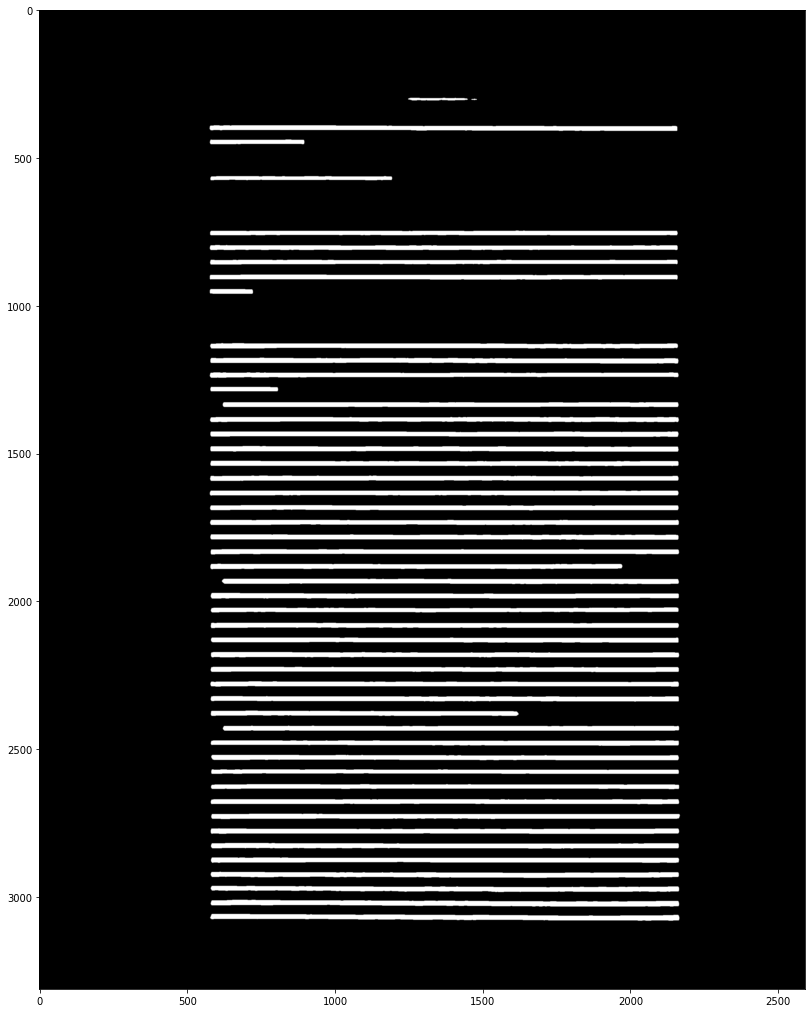

In [48]:
figsize(24, 18); imshow(pr.lineseg.segments,interpolation="bilinear")